In [2]:
import h5py
import numpy as np
from scipy.signal import resample

In [ ]:
path_to_hdf5 = 'data/downstream/code-test/data/ecg_tracings.hdf5'

with h5py.File(path_to_hdf5, 'r') as hdf:
    tracings = hdf['tracings'][:] 
    print("Original shape:", tracings.shape) 
    original_samples = tracings.shape[1] 
    resampled_samples = int(original_samples * (500 / 400)) 
    resampled_tracings = np.array([resample(tracing, resampled_samples, axis=0).T for tracing in tracings])    
    truncated_tracings = resampled_tracings[:, :, :5000]
    print("Processed shape:", truncated_tracings.shape)  # (827, 5000, 12)


Original shape: (827, 4096, 12)
Truncated shape: (827, 12, 5000)


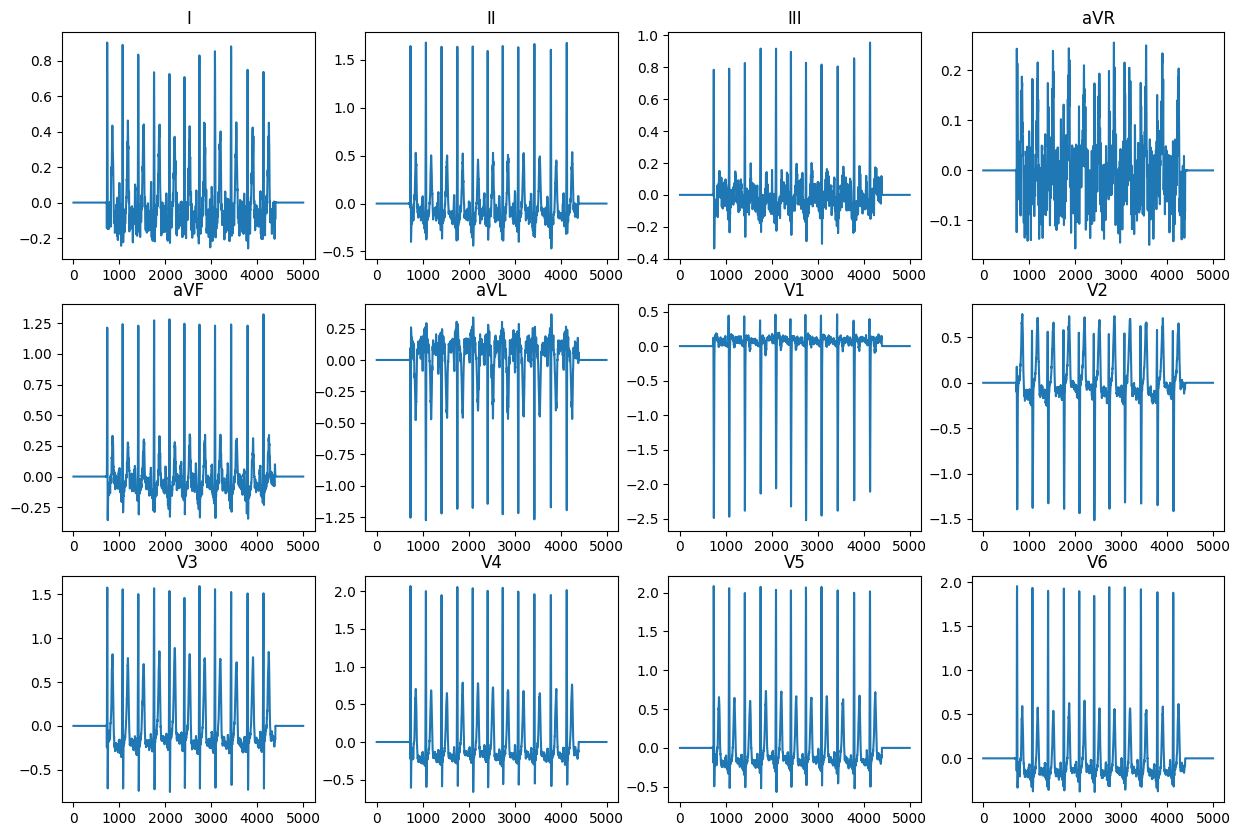

In [4]:
import matplotlib.pyplot as plt
leads = ['I', 'II', 'III', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg = truncated_tracings[np.random.randint(len(truncated_tracings))]
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for i in range(12):
    ax = axs[i // 4, i % 4]
    ax.plot(ecg[i, :])
    ax.set_title(leads[i])
plt.show()

In [ ]:
import json

# 6 classes in Code-15 dataset
all_labels = '1AVB,RBBB,LBBB,SB,AFIB,ST'.split(",")

# Look up richer context for each label. LLMTexts.json provides few other more labels as well!
with open("configs/LLMTexts.json", 'r') as file:
    converting_tool = json.load(file)

In [6]:
import pandas as pd
from sklearn.metrics import roc_auc_score

def compute_roc_auc(y_true, y_pred, model_name):
    roc_auc = []
    for i in range(y_true.shape[1]): 
        auc = roc_auc_score(y_true[:, i], y_pred[:, i], average='macro', multi_class='ovo')
        roc_auc.append(auc)
    print(f"ROC AUC scores for {model_name}: {np.mean(roc_auc)}")
    return roc_auc

In [ ]:
# We need to calculate ROC AUC for each baseline setting! 
csv_path = 'data/downstream/code-test/data/annotations/gold_standard.csv'
df = pd.read_csv(csv_path)
diagnoses_test = df.values 

y_true = pd.read_csv('data/downstream/code-test/data/annotations/gold_standard.csv').values
y_cardio = pd.read_csv('data/downstream/code-test/data/annotations/cardiology_residents.csv').values
y_emerg = pd.read_csv('data/downstream/code-test/data/annotations/emergency_residents.csv').values
y_student = pd.read_csv('data/downstream/code-test/data/annotations/medical_students.csv').values
y_neuralnet = pd.read_csv('data/downstream/code-test/data/annotations/dnn.csv', usecols=range(1, 7)).values

model_names = ["Fully Trained DNN", "Cardiology Residents", "Emergency Residents", "Medical Students"]
model_predictions = [y_neuralnet, y_cardio, y_emerg, y_student]

for model_name, y_pred in zip(model_names, model_predictions):
    compute_roc_auc(y_true, y_pred, model_name)

ROC AUC scores for Fully Trained DNN: 0.9659994995269608
ROC AUC scores for Cardiology Residents: 0.9207702067848343
ROC AUC scores for Emergency Residents: 0.9051381516474534
ROC AUC scores for Medical Students: 0.9361089491663092


In [ ]:
import torch
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import json
from transformers import T5TokenizerFast
from models.dbeta import DBETA
from types import SimpleNamespace


def load_encoders(checkpoint_path):
    with open('configs/config.json', 'r') as json_file:
        cfg = json.load(json_file)

    cfg = SimpleNamespace(**cfg['model'])
    model = DBETA(cfg)
    checkpoint = torch.load(checkpoint_path)
    if "ecg_encoder.mask_emb" in checkpoint["model"].keys():
        del checkpoint["model"]["ecg_encoder.mask_emb"]

    model.load_state_dict(checkpoint["model"], strict=True)
    model.eval()
    return model, model.ecg_encoder, model.language_encoder, model.unimodal_ecg_pooler, model.unimodal_language_pooler, model.multi_modal_ecg_proj, model.multi_modal_language_proj, model.class_embedding


def extract_language_features(model, texts, pooler=None, proj=None):
    model_name = "google/flan-t5-base"
    tokenizer = T5TokenizerFast.from_pretrained( 
            model_name, do_lower_case="uncased" in model_name
        ) 
    features_dict = {}
    
    for text in tqdm(texts):
        encoded_input = tokenizer(text, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**encoded_input)[0]
            outputs = proj(outputs)
            if pooler is None:
                max_pooled_features, _ = torch.max(outputs, dim=1)  
            else:
                max_pooled_features = pooler(outputs)
            
            features_dict[text] = max_pooled_features.numpy().squeeze(0)

    print("Successfully Extracted Language Features !!!")
    
    return features_dict
    
    
def extract_ecg_features(model, ecgs, pooler=None, proj=None, class_embedding=None, batch_size=100):
    features = []
    num_ecgs = len(ecgs)
    padding_mask = torch.zeros(batch_size, 12, 5000, dtype=torch.bool)
    
    for start_idx in tqdm(range(0, num_ecgs, batch_size)):
        end_idx = min(start_idx + batch_size, num_ecgs)
        ecg_batch = torch.tensor(ecgs[start_idx:end_idx], dtype=torch.float32)
        
        with torch.no_grad():

            uni_modal_ecg_feats, ecg_padding_mask = (
                model.get_embeddings(ecg_batch, padding_mask=None)
            )
            
            cls_emb = class_embedding.repeat((len(uni_modal_ecg_feats), 1, 1))
            uni_modal_ecg_feats = torch.cat([cls_emb, uni_modal_ecg_feats], dim=1)
            uni_modal_ecg_feats = model.get_output(uni_modal_ecg_feats, ecg_padding_mask)
            out = proj(uni_modal_ecg_feats)
            ecg_features = pooler(out)
            
            features.append(ecg_features.numpy())
            
    print("Successfully Extract Features !!!")
    
    return np.concatenate(features, axis=0)


def zero_shot(checkpoint_path, model_name=None):
    print(f"Evaluating {model_name} ...")
    model, ecg_model, language_model, unimodal_ecg_pooler, unimodal_language_pooler, multi_modal_ecg_proj, multi_modal_language_proj, class_embedding = load_encoders(checkpoint_path)
    potential_labels = [converting_tool[i].lower() for i in all_labels]
    potential_language_features_dict = extract_language_features(language_model, potential_labels, unimodal_language_pooler, multi_modal_language_proj)
    ecg_features = extract_ecg_features(ecg_model, truncated_tracings, unimodal_ecg_pooler, multi_modal_ecg_proj, class_embedding, batch_size=100)   

    all_similarities = []
    all_actual_labels = []
    
    for i, ecg_feature in tqdm(enumerate(ecg_features)):
        ecg_feature = torch.tensor(ecg_feature)

        similarities = []
        for _, potential_feature in potential_language_features_dict.items():
            potential_feature = torch.tensor(potential_feature).reshape(1, -1)
            ecg_feature = ecg_feature.reshape(1, -1)
            sim_score = ecg_feature @ potential_feature.T
            similarities.append(sim_score[0][0].item())
        
        all_similarities.append(similarities)

    all_similarities = np.array(all_similarities)
    
    all_actual_labels = np.array(diagnoses_test)

    n_classes = 6
    
    aucs = []
    for i in range(n_classes):
        auc = roc_auc_score(all_actual_labels[:, i], all_similarities[:, i], average='macro', multi_class='ovo')
        aucs.append(auc)
        print(f"AUC at class {all_labels[i]}: ", auc)
    
    average_auc = np.mean(aucs)
    print(f"Zero-shot classification AUC: {average_auc:.4f}")
    
    return average_auc

In [ ]:
average_auc = zero_shot("checkpoints/sample.pt", "sample") 

Evaluating best ...
